# Data Preparation (and low-key EDA)

Clean Data, transform to RFM-Format. Check Pareto Principle / distribution of sales & customers. 

Note: This is the same data as in the 'customer_life_time_calculatio' project. I performed some EDA there, so I have focused on data preparation here (apart from a small analysis part at the end of this notebook).

### Data Sources
- `data/OnlineRetail.xlsx`: A transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. Many customers of the company are wholesalers.

### Data Output
- `data/interim/rfm_data.csv`: Transformed data, a customer-level dataset wit recency, frequency, and monetary value columns. Will be used for modelling in the coming notebooks.

### Changes

- 2019-02-18: Start project
- 2019-02-19: Finish notebook



---

### Import libraries, load data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
# Import data
transaction_data = pd.read_excel('data/raw/OnlineRetail.xlsx')

## 1) Prepare Data
### Assess basic data structure

In [3]:
transaction_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Clean data 

Note: EDA for this set was performed in the `calculate customer lifetime value` project. These are the main findings:

**Observations:**
- 90% of orders from UK
- 305 days with orders in period
- selling about 4000+ different products
- 4373 customers
- approx 25% of transactions without customerID

Need for cleaning:
- drop orders with quantities <= 0 (are returns)   # could also be kept and marked as such
- drop orders with unit_price <= 0 (are returns)   # could also be kept and marked as such
- drop orders with missing customer ID
- add new column sales (quant * price)
- set period to 1 year exactly (to make things clean)
- normalize dates to days (remove time)
- include customers from UK only (to exclude any possible bias from origin of customers)
- drop cols we won't need no more
- group by invoice numbers (sum sales)

In [34]:
# Clean according to list
transactions = transaction_data.copy()
transactions = transactions[pd.notnull(transactions['CustomerID'])]
# transactions = transactions.loc[transactions['CustomerID'] != np.nan]
# transactions = transactions.loc[transactions['CustomerID'] != 'nan']
transactions = transactions.loc[transactions['Quantity'] > 0]
transactions = transactions.loc[transactions['UnitPrice'] > 0]
transactions = transactions.loc[transactions['Country'] == 'United Kingdom']
transactions = transactions.loc[transactions['InvoiceDate'] >= '2010-12-09']
transactions['InvoiceDate'] = pd.to_datetime(transactions['InvoiceDate'].dt.date)
transactions['CustomerID'] = transactions['CustomerID'].astype(str).str.split('.').str.get(0)
transactions['Sales'] = transactions['Quantity'] * transactions['UnitPrice']
transactions.drop(['StockCode', 'Description', 'Country',
                   'UnitPrice', 'Quantity'], inplace=True, axis=1)

assert transactions.isnull().sum().sum() == 0, "NaN in the Set"

# Create df grouped by purchase (InvoiceNo)
rfm_monetary = pd.DataFrame(transactions.groupby('InvoiceNo')['Sales'].sum())
rfm_customer = pd.DataFrame(transactions.groupby('InvoiceNo')['CustomerID'].max())
rfm_date = pd.DataFrame(transactions.groupby('InvoiceNo')['InvoiceDate'].max())
rfm_input = pd.concat([rfm_customer, rfm_date, rfm_monetary], axis=1, sort=True)

In [35]:
# Check new shape
print("unique customers: ", rfm_input['CustomerID'].nunique())
print("unique transactions: ", len(rfm_input))

unique customers:  3862
unique transactions:  16014


### Create RFM-Metrics
Create a customer-level dataset and add recency, frequency, and monetary value data to it. Attention, the definitions of recency and frequency differ from those in the lifetimes package (CLV project)!

- `recency`: the number of days that have elapsed since the customer last purchased something 
- `frequency`: number of days with purchases during the year. Monetary value is the amount that the customer spent during the year. 

In [37]:
rfm_input.head()

,CustomerID,InvoiceDate,Sales
InvoiceNo,,,
537879,14243,2010-12-09,213.30
537880,12963,2010-12-09,365.80
537881,15513,2010-12-09,956.50
537882,15079,2010-12-09,141.95
537883,14437,2010-12-09,63.00


In [38]:
rfm_value = rfm_input.groupby('CustomerID')['Sales'].sum()
rfm_frequency = rfm_input.groupby('CustomerID')['Sales'].count()
rfm_date = rfm_input.groupby('CustomerID')['InvoiceDate'].max()
rfm_data = pd.concat([rfm_value, rfm_frequency, rfm_date], axis=1, sort=True)
rfm_data.columns = ['sales', 'frequency', 'last_date']

In [39]:
# Check results
rfm_data.head()

,sales,frequency,last_date
CustomerID,,,
12346,77183.60,1,2011-01-18
12747,3837.45,10,2011-12-07
12748,31854.58,195,2011-12-09
12749,4090.88,5,2011-12-06
12820,942.34,4,2011-12-06


In [40]:
# Calculate recency
now_date = np.datetime64('2011-12-10', 'D')  # day after last date in set
rfm_data['recency'] = now_date - rfm_data['last_date']
rfm_data['recency'] = rfm_data['recency'].astype(str).str.split().str.get(0).astype(np.int64)
rfm_data.drop(['last_date'], axis=1, inplace=True)

In [41]:
rfm_data.head()

,sales,frequency,recency
CustomerID,,,
12346,77183.60,1,326
12747,3837.45,10,3
12748,31854.58,195,1
12749,4090.88,5,4
12820,942.34,4,4


In [42]:
# Save to file
rfm_data.to_csv('data/interim/rfm_data.csv')

## 2) Check Sales & Customer Distribution, Pareto Principle

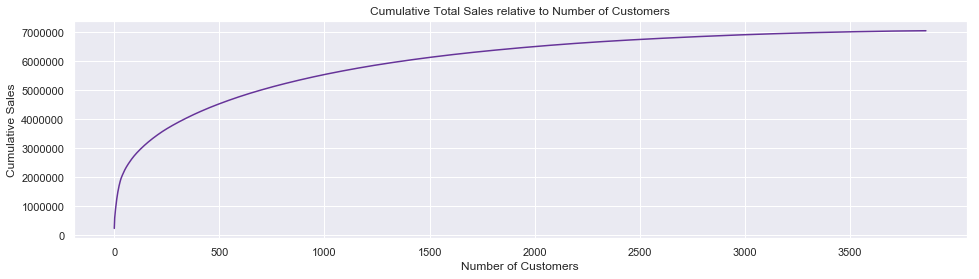

In [43]:
# Plot cumulative total amount spent by number of customers
cum_sales = np.cumsum(np.sort(rfm_data['sales'].values)[::-1])

plt.figure(figsize=(16,4))
sns.lineplot(data=cum_sales, color=color);
plt.xticks(range(0,4000,500))
plt.title("Cumulative Total Sales relative to Number of Customers", fontsize = 12)
plt.ylabel("Cumulative Sales", fontsize = 12)
plt.xlabel("Number of Customers", fontsize = 12);

In [49]:
# Prepare 'Pareto DataFrame'
rfm_pareto = rfm_data.copy()
rfm_pareto = rfm_pareto.sort_values(['sales'], ascending=False)
rfm_pareto['cum_sales'] = cum_sales
rfm_pareto['cum_prop'] = rfm_pareto['cum_sales'] / rfm_pareto['sales'].sum()
rfm_pareto.head()

# Print some thresholds
threshholds = [0.3, 0.5, 0.8]
for threshhold in threshholds:
    n_customers = len(rfm_pareto.loc[rfm_pareto['cum_prop'] <= threshhold]) + 1
    prop_customers = round((n_customers / len(rfm_pareto)) * 100, 1)
    print("{}% of customers generate {}% of total sales".format(prop_customers,
                                                                threshhold * 100))

1.1% of customers generate 30.0% of total sales
5.7% of customers generate 50.0% of total sales
27.7% of customers generate 80.0% of total sales


**Observation:** Altough the pareto principle (20/80 rule) is not fully met, there are some big outlier customers generating a large amount of total sales and there is a long tail of low spenders.

---